# Spatial Interaction

The notebook for handling spatial interaction for the urban simulation module.

## Overview

The structure of this notebook is as follows.

- Preparation of required libraries and data and defining functions for spatial interaction models
- Predicting the parameters by estimating the total flows using the original data

## Preparation

First, we will prepare the required libraries and load the data.

In [1]:
# load libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt

In [2]:
%%script echo skipping

# load data

data_path = os.path.join('data', 'london_flows.csv')
od_tube_df = pd.read_csv(data_path)


Couldn't find program: 'echo'


In [3]:
%%script echo skipping

# create matrix table of observed

od_matrix = od_tube_df.pivot_table(
    values = 'flows', index = 'station_origin', 
    columns = 'station_destination', aggfunc = 'sum', margins = True
)

od_matrix

Couldn't find program: 'echo'


### Defining Spatial Interaction Functions

Define the functions that run the spatial interaction model. This section will be considered later.


In [4]:
# define the spatial interaction models

def spatial_interaction(
        df: pd.DataFrame,
        subset = 'all',
        orig_field = 'station_origin',
        dest_field = 'station_destination',
        Oi_field = 'population',
        Dj_field = 'jobs',
        cij_field = 'distance',
        actual = 'flows',
        cost_function = 'pow'
):
    """
    Runs the models of spatial interaction and annotates results to the original dataframe.
    Returns the original dataframe with results annotated, along with the regression model for each of the spatial interaction model.
    Requires statsmodels.api as sm, statsmodels.formula.api as smf

    Parameters
    ----------
    df : pd.DataFrame
        pandas DataFrame that includes the data for OD analysis
    subset : list
        list of names of boroughs used for analysis, or 'all' (default) to use the whole dataset
    orig_field : str
        the name of column for origin
    dest_field : str
        the name of column for destination
    Oi_field : str
        the name of column for origin statistic
    Dj_field : str
        the name of column for destination statistic
    cij_field : str
        the name of column for distance statistic
    actual : str
        the name of column for the actual value observed
    cost_function : str
        string showing which cost function to use. 'exp' for negative exponential, 'pow' for inverse power

    Returns
    -------
    return_df
        a dataframe with annotated data
        adds the following 4 columns to the original dataframe:
        'unconstrained_est', 
        'origin_constrained_est', 
        'destination_constrained_est', 
        'doubly_constrained_est'

    models
        a dictionary of Generalized Linear Model wrapper objects, including 4 models indexed as:
        'unconstrained', 
        'origin_constrained', 
        'destination_constrained', 
        'doubly_constrained'
    }       

    """

    # create new dataframe with only the required rows and columns
    columns = [orig_field, dest_field, Oi_field, Dj_field, cij_field, actual]
    new_df = df[columns].copy().reset_index().drop(columns = 'index')
 
    # get rid of the internal flows for now
    new_df = new_df[new_df[orig_field] != new_df[dest_field]].copy()

    # subset if specified
    if (subset != 'all'):
        new_df = new_df[
            (new_df[orig_field].isin(subset)) & 
            (new_df[dest_field].isin(subset))
        ].copy()

    # get the log of origin and destination
    new_df['log_Oi'] = np.log(new_df[Oi_field])
    new_df['log_Dj'] = np.log(new_df[Dj_field])

    # get log of cost function
    # the inverse power cij ** (-beta), logged as -beta * np.log(cij)
    new_df['pow_cost'] = np.log(new_df[cij_field])

    # the negative exponential exp(-beta * cij), logged as -beta * cij
    new_df['exp_cost'] = new_df[cij_field]          

    # create formulas
    formulas = []

    for c in ['pow_cost', 'exp_cost']:
        formulas.extend(
            [
                f'{actual} ~ log_Oi + log_Dj + {c}',
                f'{actual} ~ {orig_field} + log_Dj + {c} -1',
                f'{actual} ~ log_Oi + {dest_field} + {c} -1',
                f'{actual} ~ {orig_field} + {dest_field} + {c} -1'
            ]
        ) 
    
    # run regression models
    models = []    
    
    for f in formulas:
        models.append(
            smf.glm(formula = f, data = new_df, family = sm.families.Poisson()).fit()
        )
        new_df[f'results']



    # ----- unconstrained model -----
        
    # create formula for unconstrained model
    formula_unconstrained = f'{actual} ~ log_Oi + log_Dj + log_cost'

    # run regression
    unco_sim = smf.glm(
        formula = formula_unconstrained,
        data = new_df,
        family = sm.families.Poisson()
    ).fit()

    # assign the parameter values
    K_unconstrained = unco_sim.params['Intercept']
    alpha_unconstrained = unco_sim.params['log_Oi']
    gamma_unconstrained = unco_sim.params['log_Dj']
    beta_unconstrained = -unco_sim.params['log_cost']

    # calculated the unconstrained value
    new_df['unconstrained_est'] = round(
        np.exp(
            (alpha_unconstrained * new_df['log_Oi'])
            + (gamma_unconstrained * new_df['log_Dj']) 
            - (beta_unconstrained * new_df['log_cost'])
            + K_unconstrained
        ), 0).astype(int)
    
    # append column to the returning dataframe
    columns.append('unconstrained_est')

    # ----- Origin Constrained Model -----

    # create formula for origin constrained model
    formula_origin_constrained = f'Total ~ {orig_field} + log_Dj + log_cost -1'

    orig_sim = smf.glm(
        formula = formula_origin_constrained,
        data = new_df,
        family = sm.families.Poisson()
    ).fit()

    # assign parameter values
    alpha_i_orco = pd.DataFrame(orig_sim.params).reset_index().rename(columns = {0:'alpha_i', 'index': 'coef'})
    gamma_orco = orig_sim.params['log_Dj']
    beta_orco = -orig_sim.params['log_cost']

    # fix indeces
    to_repl = ["(" + orig_field + ")\[", "(" + dest_field + ")\[", "\]"]
    for x in to_repl:
        alpha_i_orco['coef'] = alpha_i_orco['coef'].str.replace(x, '', regex = True)

    # join with original dataframe
    new_df = new_df.merge(alpha_i_orco, left_on = orig_field, right_on = 'coef', how = 'left').drop(columns = ['coef'])

    # calculated the origin-constrained estimated value
    new_df['origin_constrained_est'] = round(
        np.exp(
            new_df['alpha_i'] 
            + (gamma_orco * new_df['log_Dj']) 
            - (beta_orco * new_df['log_cost'])
        ), 0).astype(int)
    
    # append column to the returning dataframe
    columns.append('origin_constrained_est')

    # ----- Destination Constrained Model -----

    # create formula for destination constrained model
    formula_dest_constrained = f'Total ~ log_Oi + {dest_field} + log_cost -1'

    dest_sim = smf.glm(
        formula = formula_dest_constrained,
        data = new_df,
        family = sm.families.Poisson()
    ).fit()

    # assign parameter values
    alpha_deco = dest_sim.params['log_Oi']
    gamma_j_deco = pd.DataFrame(dest_sim.params).reset_index().rename(columns = {0:'gamma_j', 'index': 'coef'})
    beta_deco = -dest_sim.params['log_cost']

    # fix indeces
    for x in to_repl:
        gamma_j_deco['coef'] = gamma_j_deco['coef'].str.replace(x, '', regex = True)

    # join with original dataframe
    new_df = new_df.merge(gamma_j_deco, left_on = dest_field, right_on = 'coef', how = 'left').drop(columns = ['coef'])

    # calculated the origin-constrained estimated value
    new_df['destination_constrained_est'] = round(
        np.exp(
            (alpha_deco * new_df['log_Oi']) 
            + new_df['gamma_j'] 
            - (beta_deco * new_df['log_cost'])
        ), 0).astype(int)
    
    # append column to the returning dataframe
    columns.append('destination_constrained_est')

    # ----- Doubly Constrained Model -----

    # create formula for doubly constrained model
    formula_double_constrained = f'Total ~ {orig_field} + {dest_field} + log_cost -1'

    double_sim = smf.glm(
        formula = formula_double_constrained,
        data = new_df,
        family = sm.families.Poisson()
    ).fit()

    # assign parameter values
    coefs_dbl = pd.DataFrame(double_sim.params).reset_index().rename(columns = {0:'value', 'index': 'coef'})
    alpha_i_dbl = coefs_dbl[coefs_dbl.coef.str.startswith(orig_field)].rename(columns = {'value': 'alpha_i_dbl'})
    gamma_j_dbl = coefs_dbl[coefs_dbl.coef.str.startswith(dest_field)].rename(columns = {'value': 'gamma_j_dbl'})
    beta = -double_sim.params['log_cost']

    # calculated the origin-constrained estimated value
    new_df['doubly_constrained_est'] = np.round(double_sim.mu, 0)
    
    # append column to the returning dataframe
    columns.append('doubly_constrained_est')
    # create returning dataframe
    return_df = new_df[columns].copy()

    # create a dictionary of returning models
    models = {
        'unconstrained': unco_sim,
        'origin_constrained': orig_sim,
        'destination_constrained': dest_sim,
        'doubly_constrained': double_sim
    }

    # return dataframe and summaries for each model
    return return_df, models

In [5]:
# define the goodness-of-fit models

# R-squared
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2


## Running the doubly constrained spatial interaction model

I will run the doubly constrained spatial interaction model to consider the spatial decay.

In [6]:
%%script echo skipping

# remove journeys starting and finishing in the same station

od_df_new = od_tube_df[od_tube_df['station_origin'] != od_tube_df['station_destination']].copy()

Couldn't find program: 'echo'


In [7]:
%%script echo skipping

# calculate cost functions

# inverse power cij ** (-beta), logged as -beta * np.log(cij)
od_df_new['pow_cost'] = np.log(od_df_new['distance'])
# the negative exponential exp(-beta * cij), logged as -beta * cij
od_df_new['exp_cost'] = od_df_new['distance']   

# do the calculation for doubly constrained models - to calculate the -beta and the optimal exponential relationship
formula_pow = 'flows ~ station_origin + station_destination + pow_cost -1'
formula_exp = 'flows ~ station_origin + station_destination + exp_cost -1'

dbl_pow_model = smf.glm(
    formula = formula_pow,
    data = od_df_new,
    family = sm.families.Poisson()
).fit()

od_df_new['pred_pow'] = dbl_pow_model.mu

dbl_exp_model = smf.glm(
    formula = formula_exp,
    data = od_df_new,
    family = sm.families.Poisson()
).fit()

od_df_new['pred_exp'] = dbl_exp_model.mu

Couldn't find program: 'echo'


In [8]:
%%script echo skipping

# calculate O_i and D_j

O_i = pd.DataFrame(od_df_new.groupby('station_origin')['flows'].sum()).rename(columns = {'flows': 'O_i'})
D_j = pd.DataFrame(od_df_new.groupby('station_destination')['flows'].sum()).rename(columns = {'flows': 'D_j'})

# merge with original data frame
od_df_new = od_df_new.merge(O_i, on = 'station_origin', how = 'left').merge(D_j, on = 'station_destination', how = 'left')

Couldn't find program: 'echo'


In [9]:
%%script echo skipping

print(f"beta for power model: {dbl_pow_model.params['pow_cost']}")
print(f"beta for exp model: {dbl_exp_model.params['exp_cost']}")

beta_power = -dbl_pow_model.params['pow_cost']
beta_exp = -dbl_exp_model.params['exp_cost']

# save the logged cost function with calibrated beta

od_df_new['beta_dist_pow'] = beta_power * od_df_new['pow_cost']
od_df_new['beta_dist_exp'] = beta_exp * od_df_new['exp_cost']


Couldn't find program: 'echo'


In [10]:
%%script echo skipping

# save to csv
od_df_new.to_csv('data/london_flows_pred1.csv')

Couldn't find program: 'echo'


In [11]:
# load data with the above saved

od_df_new = pd.read_csv('data/london_flows_pred1.csv')

# load the parameters
beta_power = 0.9096317604932787
beta_exp = 0.0001543696921559684

In [12]:
pred_exp_matrix = od_df_new.pivot_table(
    values = 'pred_exp', index = 'station_origin', 
    columns = 'station_destination', aggfunc = 'sum', margins = True
)

pred_exp_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.622014,5.990000e+02
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.469541,NaN,NaN,1.224000e+03
Acton Town,NaN,NaN,NaN,10.886281,9.791210,NaN,16.650312,0.070891,NaN,12.193996,...,40.470717,3.999578,2.137517,18.521361,NaN,0.216578,NaN,0.866650,NaN,3.745000e+03
Aldgate,NaN,NaN,1.436803,NaN,32.113611,NaN,NaN,0.006153,NaN,23.242135,...,6.912031,NaN,3.070407,2.092522,NaN,0.708506,NaN,0.966589,NaN,2.886000e+03
Aldgate East,NaN,NaN,1.511900,37.571466,NaN,NaN,0.369446,0.006473,NaN,24.450375,...,7.273300,0.718794,3.230022,2.201301,NaN,0.966044,NaN,1.016837,NaN,3.172000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.538469,38.132867,44.441013,NaN,NaN,NaN,NaN,25.378139,...,7.401117,NaN,7.019473,NaN,NaN,NaN,NaN,NaN,NaN,4.868000e+03
Woodgrange Park,NaN,1.531378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.300000e+02
Woodside Park,NaN,NaN,2.019784,17.068105,15.347081,NaN,0.493552,NaN,NaN,25.327956,...,9.716580,NaN,4.439803,NaN,NaN,NaN,NaN,NaN,NaN,3.093000e+03


In [13]:
print(f"Exponential: {CalcRSquared(od_df_new['flows'], od_df_new['pred_exp'])}")
print(f"Power: {CalcRSquared(od_df_new['flows'], od_df_new['pred_pow'])}")


Exponential: 0.4979027747356171
Power: 0.4077121206134792


### Result of Calibration

The exponential model seems to have a better fit, with the beta value being $\beta = 0.00015436969215638512$

Further analysis will be done using this parameter.

Things to consider - should we use the doubly constrained model to calibrate, or the singly constrained?


### Calibrating using the doubly constrained model

Using the cost function calibrated by the doubly constrained model, now consider the singly constrained model for further calibration.

In [14]:
# subset the dataset where there is a valid population and jobs
od_df_new = od_df_new[(od_df_new['population'] != 0) & (od_df_new['jobs'] != 0)]

In [15]:
# origin constrained model, taking into account the beta value

# calculate the flow and the beta values
od_df_new['flow_beta_dist'] = od_df_new['flows'] * np.exp(od_df_new['beta_dist_exp'])

formula_orig_constrained2 = 'flow_beta_dist ~ station_origin + np.log(jobs) -1' 

orig_model2= smf.glm(
    formula = formula_orig_constrained2,
    data = od_df_new,
    family = sm.families.Poisson()    
).fit()

In [16]:
formula_orig_constrained_offset = 'flows ~ station_origin + np.log(jobs) -1' 

orig_model2_offset = smf.glm(
    formula = formula_orig_constrained_offset,
    data = od_df_new,
    family = sm.families.Poisson(),
    offset = -od_df_new['beta_dist_exp']    
).fit()

In [17]:
# save the above results back into the data frame

od_df_new['flow_pred_model2'] = orig_model2.mu
od_df_new['flow_pred_model2_offset'] = orig_model2_offset.mu


In [18]:
# get the parameters

Ai_offset = pd.DataFrame(orig_model2_offset.params[:-1]).reset_index().rename(columns = {'index': 'name', 0: 'Ai_model2_offset'})
gamma_offset = orig_model2_offset.params['np.log(jobs)']

In [19]:
gamma_offset

0.7555742138219249

In [20]:
# remove annotations

replace = ['station_origin[', ']']

for r in replace:
    Ai_offset['name'] = Ai_offset['name'].str.replace(r, '')

Ai_offset

,name,Ai_model2_offset
0,Abbey Road,-2.913172
1,Acton Central,-1.154278
2,Acton Town,-1.603018
3,Aldgate,-2.940727
4,Aldgate East,-2.852326
...,...,...
393,Wood Street,-0.933533
394,Woodford,-0.618684
395,Woodgrange Park,-0.889927
396,Woodside Park,-1.133885


In [21]:
# merge A_i with original dataframe

od_df_merged = od_df_new.merge(Ai_offset, how = 'left', left_on = 'station_origin', right_on = 'name').drop(columns = 'name').copy()

od_df_merged

,Unnamed: 0,station_origin,station_destination,flows,population,jobs,distance,pow_cost,exp_cost,pred_pow,pred_exp,O_i,D_j,beta_dist_pow,beta_dist_exp,flow_beta_dist,flow_pred_model2,flow_pred_model2_offset,Ai_model2_offset
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003504,8131.525097,54.840694,76.846663,599,78549,8.189873,1.255261,0.000000,200.861427,77.324070,-2.913172
1,1,Abbey Road,Beckton,1,599,442,8510.121774,9.049012,8510.121774,2.061926,2.677506,599,442,8.231268,1.313705,3.719930,4.262041,1.455807,-2.913172
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236275,3775.448872,2.697948,3.665771,599,665,7.491977,0.582815,5.373219,5.775139,4.116836,-2.913172
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534348,5086.514220,76.517784,111.884860,599,58772,7.763114,0.785204,2.192853,161.883791,99.375245,-2.913172
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709274,2228.923167,45.398702,47.768459,599,15428,7.012600,0.344078,52.195490,59.865275,56.230648,-2.913172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,61451,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,9.503144,13401.795549,256.673280,185.497591,7892,3342,8.644362,2.068831,1005.276734,817.128801,98.351207,0.526401
61409,61452,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071245,8701.454361,152.447409,176.151791,7892,5487,8.251493,1.343241,2329.515798,1181.533309,295.526341,0.526401
61410,61453,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162905,9536.720451,19.538537,26.589485,7892,400,8.334869,1.472181,26.152377,168.489172,35.917221,0.526401
61411,61454,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585832,5355.248554,115.297649,131.895731,7892,893,7.809946,0.826688,185.144616,306.191787,125.653447,0.526401


In [22]:
# calculate using the Poisson Distribution of the Model
# make sure this matches with the 'flow_pred_model2_offset' column

od_df_merged['flow_pred_model2o_value'] = np.exp(od_df_merged['Ai_model2_offset']  + gamma_offset * np.log(od_df_merged['jobs']) - od_df_merged['beta_dist_exp'])

In [23]:
# calculate using the original formula of the model
# make sure this matches with the 'flow_pred_model2_offset' column as well

od_df_merged['Ai_temp_orig'] = (od_df_merged['jobs'] ** gamma_offset) / np.exp(od_df_merged['beta_dist_exp'])

# calculate required values
Ai_original = od_df_merged.groupby('station_origin').agg(
    {
        'Ai_temp_orig': 'sum',
        'flows': 'sum',
        'population': 'mean'
    }
)

# calculate the Ai
Ai_original['Ai_original'] = 1 / (Ai_original['Ai_temp_orig'])

# merge with original dataframe
od_df_merged = od_df_merged.merge(Ai_original['Ai_original'], left_on = 'station_origin', right_index = True, how = 'left')

od_df_merged['flow_pred_model2o_value2'] = od_df_merged['Ai_original'] * od_df_merged['O_i'] * (od_df_merged['jobs'] ** gamma_offset) / np.exp(od_df_merged['beta_dist_exp'])


In [24]:
# show pivot table
od_df_merged.pivot_table(values = 'flow_pred_model2o_value', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.424277,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.323025,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,12.819313,12.528592,NaN,13.764911,0.040957,NaN,15.857813,...,13.259740,2.884243,1.889519,19.708515,NaN,0.220085,NaN,0.528976,NaN,3745.0
Aldgate,NaN,NaN,1.296116,NaN,37.396529,NaN,NaN,0.003235,NaN,27.507400,...,2.060991,NaN,2.470096,2.026410,NaN,0.655231,NaN,0.536921,NaN,2886.0
Aldgate East,NaN,NaN,1.363981,40.267859,NaN,NaN,0.277982,0.003404,NaN,28.939966,...,2.168906,0.471778,2.598737,2.131944,NaN,0.893485,NaN,0.564883,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.391055,40.960942,51.872257,NaN,NaN,NaN,NaN,30.105256,...,2.211957,NaN,5.660195,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,0.989042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,1.917773,19.252742,18.811084,NaN,0.390846,NaN,NaN,31.551465,...,3.049507,NaN,3.759478,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [25]:
min(od_df_merged['flow_pred_model2o_value'] - od_df_merged['flow_pred_model2o_value2'])

-8.549250196665525e-11

In [26]:
# get the value for the origin constrained model

od_df_merged.pivot_table(values = 'flow_pred_model2o_value', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.424277,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.323025,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,12.819313,12.528592,NaN,13.764911,0.040957,NaN,15.857813,...,13.259740,2.884243,1.889519,19.708515,NaN,0.220085,NaN,0.528976,NaN,3745.0
Aldgate,NaN,NaN,1.296116,NaN,37.396529,NaN,NaN,0.003235,NaN,27.507400,...,2.060991,NaN,2.470096,2.026410,NaN,0.655231,NaN,0.536921,NaN,2886.0
Aldgate East,NaN,NaN,1.363981,40.267859,NaN,NaN,0.277982,0.003404,NaN,28.939966,...,2.168906,0.471778,2.598737,2.131944,NaN,0.893485,NaN,0.564883,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.391055,40.960942,51.872257,NaN,NaN,NaN,NaN,30.105256,...,2.211957,NaN,5.660195,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,0.989042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,1.917773,19.252742,18.811084,NaN,0.390846,NaN,NaN,31.551465,...,3.049507,NaN,3.759478,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [27]:
od_df_merged.pivot_table(values = 'flows', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [28]:
# calculate the R2 value
print(f"R2 for origin-constrained model: {CalcRSquared(od_df_merged['flows'], od_df_merged['flow_pred_model2o_value'])}")

R2 for origin-constrained model: 0.46803396884472115


In [29]:
# od_df_merged.to_csv('data/london_flows_pred2.csv')

## Singly Constrained model

Calibration with the singly constrained model - this will be kept for a plan B but for now unused


In [30]:
%%script echo skipping

# origin constrained model without calibrating beta

formula_orig_constrained = 'flows ~ station_origin + np.log(jobs) + exp_cost -1'

orig_model1 = smf.glm(
    formula = formula_orig_constrained,
    data = od_df_new,
    family = sm.families.Poisson()
).fit()

Couldn't find program: 'echo'


In [31]:
%%script echo skipping

# do the singly constrained model without calibrating the beta value

beta_single = -orig_model1.params['exp_cost']
gamma_single = orig_model1.params['np.log(jobs)']
Ai_single = pd.DataFrame(orig_model1.params[:-2]).reset_index().rename(columns = {'index': 'name', 0:'Ai_single'})

Couldn't find program: 'echo'


In [32]:
%%script echo skipping

replace = ['station_origin[', ']']

for r in replace:
    Ai_single['name'] = Ai_single['name'].str.replace(r, '')

Couldn't find program: 'echo'


In [33]:
%%script echo skipping

Ai_single

Couldn't find program: 'echo'


In [34]:
%%script echo skipping

od_df_new

Couldn't find program: 'echo'


In [35]:
%%script echo skipping

od_df_merged2 = od_df_new.merge(Ai_single, left_on = 'station_origin', right_on = 'name', how = 'left').drop(columns = 'name').copy()

Couldn't find program: 'echo'


In [36]:
%%script echo skipping

od_df_merged2['pred_singly'] = orig_model1.mu

Couldn't find program: 'echo'


In [37]:
%%script echo skipping

# pivot table of prediction
od_df_merged2.pivot_table(values = 'pred_singly', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

Couldn't find program: 'echo'


In [38]:
%%script echo skipping

# compare with original
od_df_merged2.pivot_table(values = 'flows', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

Couldn't find program: 'echo'


In [39]:
%%script echo skipping

od_df_merged2['pred_singly2'] = np.exp(od_df_merged2['Ai_single'] + gamma_single * np.log(od_df_merged2['jobs']) - beta_single * od_df_merged2['exp_cost'])

Couldn't find program: 'echo'


In [40]:
%%script echo skipping

# calibration of Ai value

# calculate original prediction
od_df_merged2['Ai_temp'] = (od_df_merged2['jobs'] ** gamma_single) / np.exp(od_df_merged2['beta_dist_exp'])

Ai_single2 = pd.DataFrame(1 / (od_df_merged2.groupby('station_origin')['Ai_temp'].agg('sum')))
Ai_single2.rename(columns = {'Ai_temp': 'Ai_single2'}, inplace = True)

# merge with original dataframe
od_df_merged2 = od_df_merged2.merge(Ai_single2, left_on = 'station_origin', right_index = True, how = 'left')

Couldn't find program: 'echo'


In [41]:
%%script echo skipping

# create the prediction

od_df_merged2['pred_singly3'] = od_df_merged2['Ai_single2'] * od_df_merged2['O_i'] * (od_df_merged2['jobs'] ** gamma_single) / np.exp(od_df_merged2['beta_dist_exp'])

od_df_merged2.pivot_table(values = 'pred_singly3', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

Couldn't find program: 'echo'


In [42]:
%%script echo skipping

beta_single

Couldn't find program: 'echo'


## Scenario A

Now, let's reduce the number of jobs for Canary Wharf.

In [43]:
# read the saved file
# od_df_merged = pd.read_csv('data/london_flows_pred2.csv')

In [44]:
# copy the required columns
rows = ['station_origin', 'station_destination', 'flows', 'population', 'jobs', 'O_i', 'D_j', 'distance', 'exp_cost', 'pred_exp', 'beta_dist_exp', 'Ai_model2_offset', 'flow_pred_model2o_value']

od_df_scenarioA = od_df_merged[rows].copy()


In [45]:
# halve the jobs for Canary Wharf

od_df_scenarioA['jobs_scenarioA'] = od_df_scenarioA.apply(
    lambda row: 
        (row['jobs'] / 2) if row['station_destination'] == 'Canary Wharf' 
        else row['jobs'], axis = 1
)


### Calibration of $A_i$ value

The $A_i$ parameter should be calibrated according to the following equation from the origin-constrained model.

$$
A_i = \frac{1}{\sum_j D_j f(c_{ij})}
$$

In [46]:
# calculate original prediction
od_df_scenarioA['Ai_temp_orig'] = (od_df_scenarioA['jobs'] ** gamma_offset) / np.exp(od_df_scenarioA['beta_dist_exp'])


In [47]:
# recalibrate the A_i value
od_df_scenarioA['Ai_temp'] = (od_df_scenarioA['jobs_scenarioA'] ** gamma_offset) / np.exp(od_df_scenarioA['beta_dist_exp'])

In [48]:
# calculate required values
Ai_scenarioA = od_df_scenarioA.groupby('station_origin').agg(
    {
        'Ai_temp': 'sum',
        'flows': 'sum',
        'population': 'mean'
    }
)

In [49]:
# calculate the Ai
Ai_scenarioA['Ai_scenario'] = 1 / (Ai_scenarioA['Ai_temp'])

# merge with original dataframe
od_df_scenarioA = od_df_scenarioA.merge(Ai_scenarioA['Ai_scenario'], left_on = 'station_origin', right_index = True, how = 'left')

In [50]:
od_df_scenarioA.head(5)

,station_origin,station_destination,flows,population,jobs,O_i,D_j,distance,exp_cost,pred_exp,beta_dist_exp,Ai_model2_offset,flow_pred_model2o_value,jobs_scenarioA,Ai_temp_orig,Ai_temp,Ai_scenario
0,Abbey Road,Bank and Monument,0,599,78549,599,78549,8131.525097,8131.525097,76.846663,1.255261,-2.913172,77.324070,78549.0,1423.931571,1423.931571,0.000097
1,Abbey Road,Beckton,1,599,442,599,442,8510.121774,8510.121774,2.677506,1.313705,-2.913172,1.455807,442.0,26.808843,26.808843,0.000097
2,Abbey Road,Blackwall,3,599,665,599,665,3775.448872,3775.448872,3.665771,0.582815,-2.913172,4.116836,665.0,75.812001,75.812001,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,599,58772,5086.514220,5086.514220,111.884860,0.785204,-2.913172,99.375245,29386.0,1830.006460,1083.932207,0.000097
4,Abbey Road,Canning Town,37,599,15428,599,15428,2228.923167,2228.923167,47.768459,0.344078,-2.913172,56.230648,15428.0,1035.493793,1035.493793,0.000097


### Calculate the predicted flow

Based on the calibrated parameter, calculate the flow.

In [51]:
# create the prediction

# od_df_scenarioA['flow_pred_scenarioA'] = od_df_scenarioA['Ai_scenario'] * od_df_scenarioA['population'] * (od_df_scenarioA['jobs'] ** gamma_offset) / np.exp(od_df_scenarioA['beta_dist_exp'])
od_df_scenarioA['flow_pred_scenarioA'] = od_df_scenarioA['Ai_scenario'] * od_df_scenarioA['O_i'] * (od_df_scenarioA['jobs_scenarioA'] ** gamma_offset) / np.exp(od_df_scenarioA['beta_dist_exp'])

od_df_scenarioA.pivot_table(values = 'flow_pred_scenarioA', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.962856,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.323025,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,12.867856,12.576035,NaN,13.817035,0.041112,NaN,15.917863,...,13.309952,2.895165,1.896674,19.783147,NaN,0.220918,NaN,0.530979,NaN,3745.0
Aldgate,NaN,NaN,1.310360,NaN,37.807529,NaN,NaN,0.003271,NaN,27.809715,...,2.083642,NaN,2.497243,2.048681,NaN,0.662433,NaN,0.542822,NaN,2886.0
Aldgate East,NaN,NaN,1.382629,40.818381,NaN,NaN,0.281783,0.003450,NaN,29.335618,...,2.198559,0.478228,2.634266,2.161091,NaN,0.905700,NaN,0.572606,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.420850,41.838276,52.983299,NaN,NaN,NaN,NaN,30.750075,...,2.259334,NaN,5.781430,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,0.989042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,1.928180,19.357211,18.913156,NaN,0.392967,NaN,NaN,31.722669,...,3.066054,NaN,3.779877,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [52]:
od_df_scenarioA.pivot_table(values = 'flow_pred_model2o_value', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.424277,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.323025,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,12.819313,12.528592,NaN,13.764911,0.040957,NaN,15.857813,...,13.259740,2.884243,1.889519,19.708515,NaN,0.220085,NaN,0.528976,NaN,3745.0
Aldgate,NaN,NaN,1.296116,NaN,37.396529,NaN,NaN,0.003235,NaN,27.507400,...,2.060991,NaN,2.470096,2.026410,NaN,0.655231,NaN,0.536921,NaN,2886.0
Aldgate East,NaN,NaN,1.363981,40.267859,NaN,NaN,0.277982,0.003404,NaN,28.939966,...,2.168906,0.471778,2.598737,2.131944,NaN,0.893485,NaN,0.564883,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.391055,40.960942,51.872257,NaN,NaN,NaN,NaN,30.105256,...,2.211957,NaN,5.660195,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,0.989042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,1.917773,19.252742,18.811084,NaN,0.390846,NaN,NaN,31.551465,...,3.049507,NaN,3.759478,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


### Analyse the change in the scenario compared to the original flow

Look at the difference between the original predicted flows and scenario A.

In [53]:
# store the difference between the prediction and the original dataset
od_df_scenarioA['difference_scenarioA'] = od_df_scenarioA['flow_pred_scenarioA'] - od_df_scenarioA['flow_pred_model2o_value']

In [54]:
# create df for comparison of overall flows that terminate in the scenarios
comparison_scenarioA = od_df_scenarioA.groupby('station_destination').agg(
    {
        'flows': 'sum',
        'flow_pred_model2o_value': 'sum',
        'flow_pred_scenarioA': 'sum',
        'difference_scenarioA': 'sum'    
    }
)

# calculate ratio
comparison_scenarioA['change_ratio'] = comparison_scenarioA['flow_pred_scenarioA'] / comparison_scenarioA['flow_pred_model2o_value']

In [55]:
comparison_scenarioA.sort_values(by = 'difference_scenarioA')

,flows,flow_pred_model2o_value,flow_pred_scenarioA,difference_scenarioA,change_ratio
station_destination,,,,,
Canary Wharf,58772,47690.569044,29496.662363,-18193.906680,0.618501
Cheshunt,116,65.127624,65.161813,0.034190,1.000525
Emerson Park,42,42.114328,42.185417,0.071089,1.001688
Hatch End,93,75.811011,75.885384,0.074372,1.000981
Theobalds Grove,182,101.470131,101.571393,0.101261,1.000998
...,...,...,...,...,...
Oxford Circus,44368,39767.481280,40104.156107,336.674827,1.008466
Liverpool Street,61122,58822.030849,59345.697101,523.666252,1.008903
Canning Town,15428,16567.990357,17271.671030,703.680673,1.042472


In [56]:
comparison_scenarioA.sort_values(by = 'change_ratio')

,flows,flow_pred_model2o_value,flow_pred_scenarioA,difference_scenarioA,change_ratio
station_destination,,,,,
Canary Wharf,58772,47690.569044,29496.662363,-18193.906680,0.618501
Shenfield,933,898.168523,898.286343,0.117820,1.000131
Brentwood,742,677.299000,677.465178,0.166179,1.000245
Harold Wood,530,916.756171,917.046858,0.290687,1.000317
Gidea Park,299,690.549023,690.817405,0.268382,1.000389
...,...,...,...,...,...
Lewisham,2400,925.485803,1001.350696,75.864893,1.081973
Cutty Sark,1748,1198.222658,1298.763763,100.541105,1.083909
Greenwich,1189,868.948780,944.143559,75.194779,1.086535


In [57]:
comparison_scenarioA.loc['Canary Wharf']

flows                      58772.000000
flow_pred_model2o_value    47690.569044
flow_pred_scenarioA        29496.662363
difference_scenarioA      -18193.906680
change_ratio                   0.618501
Name: Canary Wharf, dtype: float64

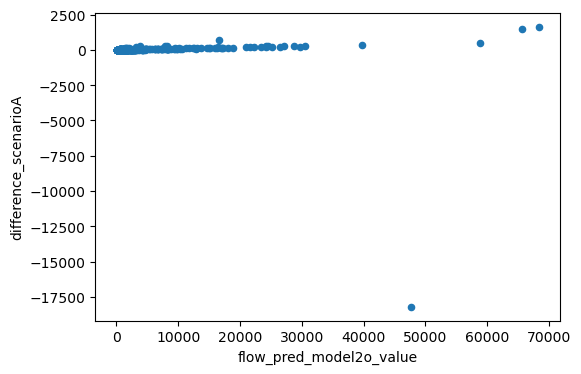

In [58]:
# plot the change to destination

# initialise plot
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

# histogram
comparison_scenarioA.plot(
    x = 'flow_pred_model2o_value',
    y = 'difference_scenarioA',
    ax = ax,
    kind = 'scatter'
)

plt.show()

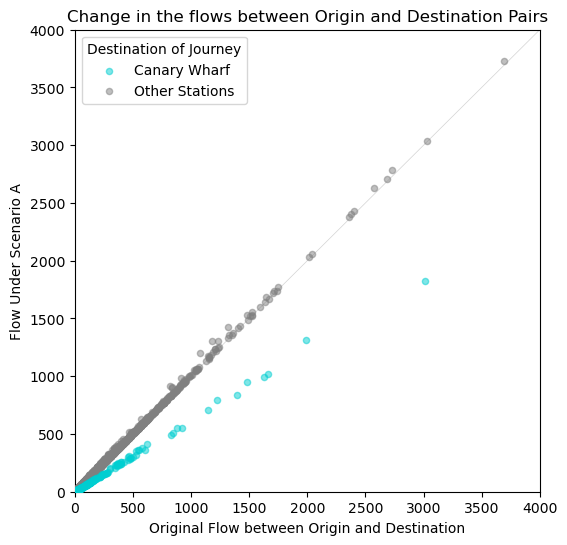

In [59]:
# plot change of individual flows

# initialise plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

# plot line for x = y
ax.plot(
    [-1000, 10000], 
    [-1000, 10000], 
    color = 'lightgray',
    lw = 0.5,
    zorder = 1
)

# histogram for Canary Wharf
od_df_scenarioA[od_df_scenarioA['station_destination'] == 'Canary Wharf'].plot(
    x = 'flow_pred_model2o_value',
    y = 'flow_pred_scenarioA',
    color = 'darkturquoise',
    alpha = 0.5,
    ax = ax,
    kind = 'scatter',
    label = 'Canary Wharf',
    zorder = 10
)

# histogram for other stations
od_df_scenarioA[od_df_scenarioA['station_destination'] != 'Canary Wharf'].plot(
    x = 'flow_pred_model2o_value',
    y = 'flow_pred_scenarioA',
    color = 'gray',
    alpha = 0.5,
    ax = ax,
    kind = 'scatter',
    label = 'Other Stations',
    zorder = 3
)

# show legend
ax.legend(title = 'Destination of Journey')

# set limits
ax.set_xlim([0, 4000])
ax.set_ylim([0, 4000])

# set axis legend
ax.set_xlabel('Original Flow between Origin and Destination')
ax.set_ylabel('Flow Under Scenario A')

# title
ax.set_title('Change in the flows between Origin and Destination Pairs')

plt.savefig('documents/img/OD_change_scenarioA', bbox_inches = 'tight')

In [60]:
# calculate the difference in flows
od_df_scenarioA['difference_scenarioA'].abs().sum() / 2

18193.906680307606

In [61]:
od_df_scenarioA

,station_origin,station_destination,flows,population,jobs,O_i,D_j,distance,exp_cost,pred_exp,beta_dist_exp,Ai_model2_offset,flow_pred_model2o_value,jobs_scenarioA,Ai_temp_orig,Ai_temp,Ai_scenario,flow_pred_scenarioA,difference_scenarioA
0,Abbey Road,Bank and Monument,0,599,78549,599,78549,8131.525097,8131.525097,76.846663,1.255261,-2.913172,77.324070,78549.0,1423.931571,1423.931571,0.000097,82.933391,5.609320
1,Abbey Road,Beckton,1,599,442,599,442,8510.121774,8510.121774,2.677506,1.313705,-2.913172,1.455807,442.0,26.808843,26.808843,0.000097,1.561415,0.105609
2,Abbey Road,Blackwall,3,599,665,599,665,3775.448872,3775.448872,3.665771,0.582815,-2.913172,4.116836,665.0,75.812001,75.812001,0.000097,4.415483,0.298648
3,Abbey Road,Canary Wharf,1,599,58772,599,58772,5086.514220,5086.514220,111.884860,0.785204,-2.913172,99.375245,29386.0,1830.006460,1083.932207,0.000097,63.130964,-36.244280
4,Abbey Road,Canning Town,37,599,15428,599,15428,2228.923167,2228.923167,47.768459,0.344078,-2.913172,56.230648,15428.0,1035.493793,1035.493793,0.000097,60.309788,4.079140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,7892,3342,13401.795549,13401.795549,185.497591,2.068831,0.526401,98.351207,3342.0,58.098710,58.098710,0.000232,106.503559,8.152352
61409,Woolwich Arsenal,West Ham,608,7892,5487,7892,5487,8701.454361,8701.454361,176.151791,1.343241,0.526401,295.526341,5487.0,174.575378,174.575378,0.000232,320.022580,24.496240
61410,Woolwich Arsenal,West India Quay,6,7892,400,7892,400,9536.720451,9536.720451,26.589485,1.472181,0.526401,35.917221,400.0,21.217271,21.217271,0.000232,38.894407,2.977186
61411,Woolwich Arsenal,West Silvertown,81,7892,893,7892,893,5355.248554,5355.248554,131.895731,0.826688,0.526401,125.653447,893.0,74.226880,74.226880,0.000232,136.068888,10.415440


## Scenario B

The second scenario is to increase the cost function for the whole system.



In [62]:
# read the saved file
# od_df_merged = pd.read_csv('data/london_flows_pred2.csv')

# copy the required columns
rows = ['station_origin', 'station_destination', 'flows', 'population', 'jobs', 'O_i', 'D_j', 'distance', 'exp_cost', 'pred_exp', 'beta_dist_exp', 'Ai_model2_offset', 'flow_pred_model2o_value']

od_df_scenarioB = od_df_merged[rows].copy()


### Visualise scenarios

The scenarios will change the distance decay function from the original $\beta = -1.543 \times 10^{-4}$ as follows:

$$
f(c_{ij}) = \exp(-\beta_k c_{ij}) \quad \text{where} \quad
\begin{cases}
\text{Scenario 1:} \quad \beta_1 = 2 \beta \\
\text{Scenario 2:} \quad \beta_2 = 10 \beta
\end{cases}
$$

In [63]:
# plot the scenario

dist_df = pd.DataFrame(np.arange(0,15000,10)).rename(columns = {0: 'distance'})
dist_df['cost_original'] = np.exp(-beta_exp * dist_df['distance'])

dist_df['cost_change2'] = np.exp(-(beta_exp * 2) * dist_df['distance'])
dist_df['cost_change10'] = np.exp(-(beta_exp * 10) * dist_df['distance'])

dist_df['cost_power'] = dist_df['distance'] ** (-beta_power)
dist_df

,distance,cost_original,cost_change2,cost_change10,cost_power
0,0,1.000000,1.000000,1.000000e+00,inf
1,10,0.998457,0.996917,9.846816e-01,0.123131
2,20,0.996917,0.993844,9.695978e-01,0.065545
3,30,0.995380,0.990781,9.547451e-01,0.045328
4,40,0.993844,0.987726,9.401199e-01,0.034891
...,...,...,...,...,...
1495,14950,0.099477,0.009896,9.489321e-11,0.000159
1496,14960,0.099324,0.009865,9.343959e-11,0.000159
1497,14970,0.099171,0.009835,9.200825e-11,0.000159
1498,14980,0.099018,0.009804,9.059882e-11,0.000159


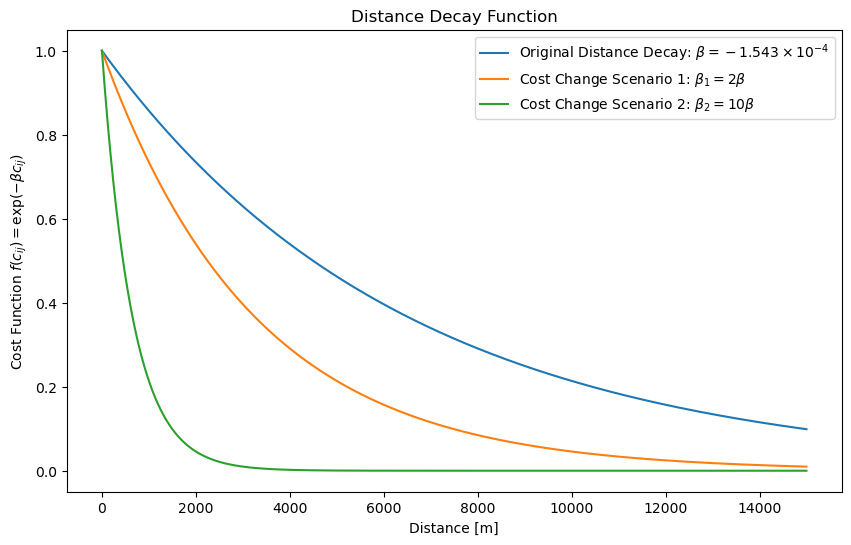

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (10 ,6))

ax.plot(dist_df['distance'], dist_df['cost_original'], label = r'Original Distance Decay: $\beta = -1.543 \times 10^{-4}$')
ax.plot(dist_df['distance'], dist_df['cost_change2'], label = r'Cost Change Scenario 1: $\beta_1 = 2\beta$')
ax.plot(dist_df['distance'], dist_df['cost_change10'], label = r'Cost Change Scenario 2: $\beta_2 = 10\beta$')

ax.legend()

# add labels
ax.set_xlabel('Distance [m]')
ax.set_ylabel(r'Cost Function $f(c_{ij}) = \exp(-\beta c_{ij})$')

# add title
ax.set_title('Distance Decay Function')

plt.savefig('documents/img/dist_decay.png', bbox_inches = 'tight')


In [65]:
# save the logged distances for each scenario

od_df_scenarioB['beta_dist_exp_b1'] = 2 * od_df_scenarioB['beta_dist_exp']
od_df_scenarioB['beta_dist_exp_b2'] = 10 * od_df_scenarioB['beta_dist_exp']

In [66]:
# calculate Ai for each scenario
od_df_scenarioB['Ai_temp_b1'] = (od_df_scenarioB['jobs'] ** gamma_offset) / np.exp(od_df_scenarioB['beta_dist_exp_b1'])
od_df_scenarioB['Ai_temp_b2'] = (od_df_scenarioB['jobs'] ** gamma_offset) / np.exp(od_df_scenarioB['beta_dist_exp_b2'])

# calculate required values
Ai_scenarioB = od_df_scenarioB.groupby('station_origin').agg(
    {
        'Ai_temp_b1': 'sum',
        'Ai_temp_b2': 'sum'
    }
)

# calculate the Ai
Ai_scenarioB['Ai_b1'] = 1 / (Ai_scenarioB['Ai_temp_b1'])
Ai_scenarioB['Ai_b2'] = 1 / (Ai_scenarioB['Ai_temp_b2'])

# merge with original dataframe
od_df_scenarioB = od_df_scenarioB.merge(Ai_scenarioB[['Ai_b1', 'Ai_b2']], left_on = 'station_origin', right_index = True, how = 'left')

# make predictions
od_df_scenarioB['flow_pred_scenarioB1'] = od_df_scenarioB['Ai_b1'] * od_df_scenarioB['O_i'] * (od_df_scenarioB['jobs'] ** gamma_offset) / np.exp(od_df_scenarioB['beta_dist_exp_b1'])
od_df_scenarioB['flow_pred_scenarioB2'] = od_df_scenarioB['Ai_b2'] * od_df_scenarioB['O_i'] * (od_df_scenarioB['jobs'] ** gamma_offset) / np.exp(od_df_scenarioB['beta_dist_exp_b2'])

In [67]:
# pivot table for B1
od_df_scenarioB.pivot_table(values = 'flow_pred_scenarioB1', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.971550,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.014621,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,3.846907,3.621778,NaN,26.216610,0.000518,NaN,5.709591,...,4.831002,1.356905,0.221207,30.359247,NaN,0.006952,NaN,0.038560,NaN,3745.0
Aldgate,NaN,NaN,0.176538,NaN,55.806758,NaN,NaN,0.000006,NaN,29.711481,...,0.201849,NaN,0.653780,0.555066,NaN,0.106562,NaN,0.068705,NaN,2886.0
Aldgate East,NaN,NaN,0.181789,61.038939,NaN,NaN,0.017194,0.000006,NaN,30.578917,...,0.207853,0.058381,0.672867,0.571271,NaN,0.184242,NaN,0.070711,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.075710,25.289703,39.976920,NaN,NaN,NaN,NaN,13.250270,...,0.086565,NaN,1.278149,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,0.036854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.270248,10.492806,9.873457,NaN,0.025560,NaN,NaN,27.332646,...,0.308994,NaN,1.058952,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [68]:
# pivot table for B2
od_df_scenarioB.pivot_table(values = 'flow_pred_scenarioB2', index = 'station_origin', columns = 'station_destination', aggfunc = 'sum', margins = True)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000207,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.664470e-15,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,1.262912e-07,8.817897e-08,NaN,2.266146e+00,1.696843e-22,NaN,8.049791e-07,...,7.487570e-07,1.625464e-06,3.896465e-12,0.480479,NaN,3.438349e-18,NaN,1.534669e-14,NaN,3745.0
Aldgate,NaN,NaN,1.326129e-09,NaN,8.704091e+01,NaN,NaN,2.821674e-29,NaN,3.490720e+00,...,1.083476e-10,NaN,9.985388e-07,0.000001,NaN,3.307226e-09,NaN,3.132026e-10,NaN,2886.0
Aldgate East,NaN,NaN,1.239513e-09,1.165191e+02,NaN,NaN,2.522390e-13,2.630325e-29,NaN,3.254000e+00,...,1.012709e-10,2.198473e-10,9.308239e-07,0.000001,NaN,4.124832e-08,NaN,2.919631e-10,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,6.839055e-17,6.264661e-06,5.836685e-05,NaN,NaN,NaN,NaN,2.189007e-07,...,5.587656e-18,NaN,1.013782e-10,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,4.150056e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,1.258899e-13,2.446747e-07,1.703797e-07,NaN,2.561840e-17,NaN,NaN,2.597072e-05,...,1.028548e-14,NaN,1.257101e-10,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [69]:
# sort in order of B1
od_df_scenarioB.sort_values(by = 'flow_pred_scenarioB1', ascending = False).head(10)

,station_origin,station_destination,flows,population,jobs,O_i,D_j,distance,exp_cost,pred_exp,...,Ai_model2_offset,flow_pred_model2o_value,beta_dist_exp_b1,beta_dist_exp_b2,Ai_temp_b1,Ai_temp_b2,Ai_b1,Ai_b2,flow_pred_scenarioB1,flow_pred_scenarioB2
55890,Waterloo,Bank and Monument,15946,67372,78549,67314,78549,2542.954444,2542.954444,4557.130349,...,0.091081,3695.843598,0.785110,3.925551,2278.625919,98.581845,0.000029,0.000379,4425.695797,2517.002873
49894,Stratford,Canary Wharf,3875,59311,58772,59311,58772,5482.674320,5482.674320,3747.421066,...,0.560154,3014.150717,1.692717,8.463587,738.455554,0.846784,0.000091,0.003536,3985.078747,177.615081
32282,Liverpool Street,Bank and Monument,812,31473,78549,31473,78549,841.502684,841.502684,2920.983468,...,-0.612540,2377.952502,0.259805,1.299025,3853.099014,1362.958468,0.000031,0.000231,3753.478129,9910.685575
32584,London Bridge,Bank and Monument,445,32597,78549,32593,78549,886.728371,886.728371,2962.303565,...,-0.593795,2406.092792,0.273768,1.368840,3799.672247,1271.049487,0.000030,0.000327,3737.373141,13554.848489
27821,Ilford,Stratford,3080,5298,55954,5298,55954,5635.299025,5635.299025,3161.510384,...,0.627154,3033.241703,1.739839,8.699194,678.791524,0.644654,0.000918,0.067971,3300.676156,232.147458
9124,Canning Town,Canary Wharf,1258,21125,58772,21125,58772,2857.591052,2857.591052,2057.742189,...,-0.437924,1666.080101,0.882251,4.411255,1660.754852,48.716798,0.000084,0.002639,2936.977519,2715.418209
56015,Waterloo,Liverpool Street,1571,67372,61122,67314,61122,3384.457128,3384.457128,2833.740980,...,0.091081,2685.239585,1.044915,5.224576,1453.873251,22.249636,0.000029,0.000379,2823.807402,568.080232
50041,Stratford,Liverpool Street,6946,59311,61122,59311,61122,6698.461270,6698.461270,2417.160482,...,0.560154,2573.484272,2.068079,10.340394,522.603413,0.133522,0.000091,0.003536,2820.231685,28.006467
49895,Stratford,Canning Town,1296,59311,15428,59311,15428,3368.590261,3368.590261,1426.449110,...,0.560154,1520.595553,1.040016,5.200082,516.303818,8.057710,0.000091,0.003536,2786.235893,1690.124133
56046,Waterloo,Oxford Circus,2425,67372,44368,67314,44368,2645.397667,2645.397667,2729.164048,...,0.091081,2362.706029,0.816738,4.083692,1433.841511,54.661450,0.000029,0.000379,2784.900451,1395.622353


In [70]:
# sort in order of B2
od_df_scenarioB.sort_values(by = 'flow_pred_scenarioB2', ascending = False).head(10)

,station_origin,station_destination,flows,population,jobs,O_i,D_j,distance,exp_cost,pred_exp,...,Ai_model2_offset,flow_pred_model2o_value,beta_dist_exp_b1,beta_dist_exp_b2,Ai_temp_b1,Ai_temp_b2,Ai_b1,Ai_b2,flow_pred_scenarioB1,flow_pred_scenarioB2
50146,Stratford,Stratford High Street,119,59311,788,59311,788,519.300074,519.300074,319.360978,...,0.560154,249.457935,0.160328,0.801642,131.495468,69.245548,0.000091,0.003536,709.615892,14524.420058
32584,London Bridge,Bank and Monument,445,32597,78549,32593,78549,886.728371,886.728371,2962.303565,...,-0.593795,2406.092792,0.273768,1.368840,3799.672247,1271.049487,0.000030,0.000327,3737.373141,13554.848489
44694,Seven Sisters,Tottenham Hale,169,18780,3239,18780,3239,1153.539168,1153.539168,351.665765,...,-0.264472,288.523845,0.356143,1.780715,314.561136,75.687011,0.000167,0.008181,987.212287,11628.204093
50186,Stratford,West Ham,277,59311,5487,59311,5487,1673.509515,1673.509515,626.393887,...,0.560154,904.526877,0.516678,2.583391,398.983136,50.511749,0.000091,0.003536,2153.114301,10594.960719
18930,Finsbury Park,Highbury & Islington,3659,24735,25385,24735,25385,2057.343960,2057.343960,978.428977,...,-0.383222,1055.906841,0.635183,3.175916,1127.530795,88.859187,0.000081,0.004754,2268.968650,10449.403287
6969,Brixton,Stockwell,33,23381,1623,23381,1623,1586.737541,1586.737541,101.792222,...,-0.335692,149.096294,0.489888,2.449442,163.259355,23.006725,0.000099,0.019087,378.567636,10267.240453
56133,Waterloo,Westminster,717,67372,15466,67314,15466,850.360026,850.360026,1297.083620,...,0.091081,1405.828283,0.262540,1.312698,1125.554374,393.811531,0.000029,0.000379,2186.125077,10054.840779
56086,Waterloo,Southwark,109,67372,10326,67314,10326,656.426930,656.426930,906.853312,...,0.091081,1067.508972,0.202665,1.013324,880.658198,391.509662,0.000029,0.000379,1710.471759,9996.069214
32282,Liverpool Street,Bank and Monument,812,31473,78549,31473,78549,841.502684,841.502684,2920.983468,...,-0.612540,2377.952502,0.259805,1.299025,3853.099014,1362.958468,0.000031,0.000231,3753.478129,9910.685575
54888,Walthamstow Central,Blackhorse Road,182,17499,2955,17499,2955,1559.063744,1559.063744,379.122092,...,0.054587,347.894930,0.481344,2.406722,258.951562,37.760497,0.000324,0.014812,1469.015699,9787.099988


In [71]:
od_df_scenarioB['distance'].describe()

count    61413.000000
mean     16322.593526
std       9400.312155
min        248.178706
25%       8947.149423
50%      15237.159477
75%      22289.476167
max      60633.323742
Name: distance, dtype: float64

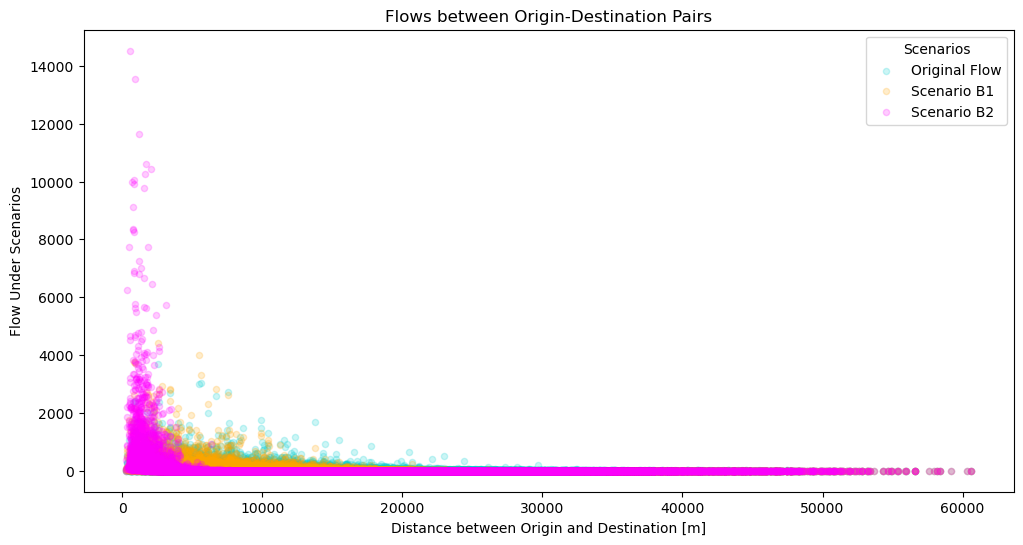

In [72]:
# plot change of individual flows

# initialise plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

# histogram for original flow
od_df_scenarioB.plot(
    x = 'distance',
    y = 'flow_pred_model2o_value',
    color = 'darkturquoise',
    alpha = 0.2,
    ax = ax,
    kind = 'scatter',
    label = 'Original Flow',
    zorder = 10
)

# histogram for scenario B1
od_df_scenarioB.plot(
    x = 'distance',
    y = 'flow_pred_scenarioB1',
    color = 'orange',
    alpha = 0.2,
    ax = ax,
    kind = 'scatter',
    label = 'Scenario B1',
    zorder = 10
)

# histogram for scenario B2
od_df_scenarioB.plot(
    x = 'distance',
    y = 'flow_pred_scenarioB2',
    color = 'magenta',
    alpha = 0.2,
    ax = ax,
    kind = 'scatter',
    label = 'Scenario B2',
    zorder = 10
)

# show legend
ax.legend(title = 'Scenarios')

# set axis legend
ax.set_xlabel('Distance between Origin and Destination [m]')
ax.set_ylabel('Flow Under Scenarios')

# title
ax.set_title('Flows between Origin-Destination Pairs')

# plt.show()
plt.savefig('documents/img/OD_change_scenarioB', bbox_inches = 'tight')


# Compare the change in flows

Let's compare the difference in flows between each of the scenarios

In [73]:
# make a dataframe for comparing scenarios
compare_scenarios = od_df_scenarioA.iloc[:, :8].copy()
compare_scenarios['flow_pred_original'] = od_df_scenarioA['flow_pred_model2o_value']
compare_scenarios['flow_pred_scenarioA'] = od_df_scenarioA['flow_pred_scenarioA']
compare_scenarios['flow_pred_scenarioB1'] = od_df_scenarioB['flow_pred_scenarioB1']
compare_scenarios['flow_pred_scenarioB2'] = od_df_scenarioB['flow_pred_scenarioB2']

compare_scenarios

,station_origin,station_destination,flows,population,jobs,O_i,D_j,distance,flow_pred_original,flow_pred_scenarioA,flow_pred_scenarioB1,flow_pred_scenarioB2
0,Abbey Road,Bank and Monument,0,599,78549,599,78549,8131.525097,77.324070,82.933391,36.698014,0.009979
1,Abbey Road,Beckton,1,599,442,599,442,8510.121774,1.455807,1.561415,0.651703,0.000111
2,Abbey Road,Blackwall,3,599,665,599,665,3775.448872,4.116836,4.415483,3.827640,0.225782
3,Abbey Road,Canary Wharf,1,599,58772,599,58772,5086.514220,99.375245,63.130964,75.465665,0.881734
4,Abbey Road,Canning Town,37,599,15428,599,15428,2228.923167,56.230648,60.309788,66.377766,26.438547
...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,7892,3342,13401.795549,98.351207,106.503559,50.193718,0.000698
61409,Woolwich Arsenal,West Ham,608,7892,5487,7892,5487,8701.454361,295.526341,320.022580,311.591570,1.438360
61410,Woolwich Arsenal,West India Quay,6,7892,400,7892,400,9536.720451,35.917221,38.894407,33.288513,0.054776
61411,Woolwich Arsenal,West Silvertown,81,7892,893,7892,893,5355.248554,125.653447,136.068888,222.075130,63.895456


In [74]:
# create columns for the parameters for comparison
predictions = ['A', 'B1', 'B2']

# create column for difference in flows
for p in predictions:
    compare_scenarios[f'difference_scenario{p}'] = compare_scenarios[f'flow_pred_scenario{p}'] - compare_scenarios['flow_pred_original']

for p in predictions:
    compare_scenarios[f'abs_diff_scenario{p}'] = compare_scenarios[f'difference_scenario{p}'].abs()

# calculate total distance of journeys
compare_scenarios['total_distance_original'] = compare_scenarios['distance'] * compare_scenarios[f'flow_pred_original']

for p in predictions:
    compare_scenarios[f'total_distance_scenario{p}'] = compare_scenarios['distance'] * compare_scenarios[f'flow_pred_scenario{p}']

compare_scenarios

,station_origin,station_destination,flows,population,jobs,O_i,D_j,distance,flow_pred_original,flow_pred_scenarioA,...,difference_scenarioA,difference_scenarioB1,difference_scenarioB2,abs_diff_scenarioA,abs_diff_scenarioB1,abs_diff_scenarioB2,total_distance_original,total_distance_scenarioA,total_distance_scenarioB1,total_distance_scenarioB2
0,Abbey Road,Bank and Monument,0,599,78549,599,78549,8131.525097,77.324070,82.933391,...,5.609320,-40.626056,-77.314092,5.609320,40.626056,77.314092,6.287626e+05,6.743749e+05,2.984108e+05,81.143940
1,Abbey Road,Beckton,1,599,442,599,442,8510.121774,1.455807,1.561415,...,0.105609,-0.804104,-1.455695,0.105609,0.804104,1.455695,1.238909e+04,1.328783e+04,5.546071e+03,0.944870
2,Abbey Road,Blackwall,3,599,665,599,665,3775.448872,4.116836,4.415483,...,0.298648,-0.289196,-3.891054,0.298648,0.289196,3.891054,1.554290e+04,1.667043e+04,1.445106e+04,852.429304
3,Abbey Road,Canary Wharf,1,599,58772,599,58772,5086.514220,99.375245,63.130964,...,-36.244280,-23.909580,-98.493511,36.244280,23.909580,98.493511,5.054736e+05,3.211165e+05,3.838572e+05,4484.952344
4,Abbey Road,Canning Town,37,599,15428,599,15428,2228.923167,56.230648,60.309788,...,4.079140,10.147118,-29.792101,4.079140,10.147118,29.792101,1.253338e+05,1.344259e+05,1.479509e+05,58929.490734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,7892,3342,13401.795549,98.351207,106.503559,...,8.152352,-48.157489,-98.350509,8.152352,48.157489,98.350509,1.318083e+06,1.427339e+06,6.726859e+05,9.356979
61409,Woolwich Arsenal,West Ham,608,7892,5487,7892,5487,8701.454361,295.526341,320.022580,...,24.496240,16.065229,-294.087980,24.496240,16.065229,294.087980,2.571509e+06,2.784662e+06,2.711300e+06,12515.825242
61410,Woolwich Arsenal,West India Quay,6,7892,400,7892,400,9536.720451,35.917221,38.894407,...,2.977186,-2.628708,-35.862444,2.977186,2.628708,35.862444,3.425325e+05,3.709251e+05,3.174632e+05,522.387472
61411,Woolwich Arsenal,West Silvertown,81,7892,893,7892,893,5355.248554,125.653447,136.068888,...,10.415440,96.421682,-61.757991,10.415440,96.421682,61.757991,6.729054e+05,7.286827e+05,1.189268e+06,342176.050096


In [75]:
# store the flow
total_flows = compare_scenarios['flows'].sum()

print(f'total flows: {total_flows:,}')

# print the values

# print the absolute difference of flows
for p in predictions:
    print(f"Absolute difference of flows for scenario {p}: {compare_scenarios[f'abs_diff_scenario{p}'].sum() / 2:.2f}")

# print percentage of reallocated flows
for p in predictions:
    print(f"Percentage of reallocaed flows for scenario {p}: {compare_scenarios[f'abs_diff_scenario{p}'].sum() * 100 / (2 * total_flows):.2f} %")


# print the mean distance of journeys
print(f"Mean distance of journeys for Original: {compare_scenarios[f'total_distance_original'].sum() / total_flows:.2f}")
for p in predictions:
    print(f"Mean distance of journeys for scenario {p}: {compare_scenarios[f'total_distance_scenario{p}'].sum() / total_flows:.2f}")

total flows: 1,542,283
Absolute difference of flows for scenario A: 18193.91
Absolute difference of flows for scenario B1: 346503.86
Absolute difference of flows for scenario B2: 1222191.80
Percentage of reallocaed flows for scenario A: 1.18 %
Percentage of reallocaed flows for scenario B1: 22.47 %
Percentage of reallocaed flows for scenario B2: 79.25 %
Mean distance of journeys for Original: 8583.00
Mean distance of journeys for scenario A: 8579.35
Mean distance of journeys for scenario B1: 6030.45
Mean distance of journeys for scenario B2: 1613.25
